<a href="https://colab.research.google.com/github/Nitzancohen1/HW1/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment1 <br>
### Names: Idan Bar Oz 206670853, Nitzan Cohen 209511187, Yanai Bardos 209540517

# Import libraries

In [ ]:
from google.colab import drive
import os
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the data

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')
df_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,count
0,2011-07-11 00:00:00,3,0,1,1,28.70,32.575,65,12.9980,5.354100,28.701,0.000000,35
1,2012-05-18 22:00:00,2,0,1,1,22.96,26.515,52,22.0028,85.425233,22.961,0.004489,251
2,2011-04-01 23:00:00,2,0,1,1,12.30,15.910,61,6.0032,2.040899,12.301,0.000242,53
3,2012-09-16 09:00:00,3,0,0,1,23.78,27.275,60,8.9981,26.682772,23.781,0.004489,296
4,2011-02-01 23:00:00,1,0,1,3,8.20,9.850,93,12.9980,5.851754,8.201,0.000000,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8159,2012-01-14 02:00:00,1,0,0,1,6.56,8.335,47,11.0014,14.953355,6.561,0.004489,38
8160,2011-12-10 09:00:00,4,0,0,1,11.48,12.880,61,19.0012,7.977025,11.481,0.000000,149
8161,2011-12-18 16:00:00,4,0,0,1,11.48,13.635,48,16.9979,6.916512,11.481,0.015615,234
8162,2011-02-19 07:00:00,1,0,0,1,15.58,19.695,17,35.0008,0.095445,15.581,0.000242,22


# Exploring the data

Description of the data

In [ ]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,count
count,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000
mean,2.510289,0.029397,0.683244,1.415483,20.244980,23.670160,61.835130,12.791334,47.152120,20.245980,0.004986,191.339784
std,1.117178,0.168928,0.465240,0.631242,7.796018,8.468725,19.255791,8.213914,72.882602,7.796018,0.006319,181.143178
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000304,0.821000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,3.693188,13.941000,0.000000,41.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,17.684113,20.501000,0.000242,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,59.257746,26.241000,0.004489,285.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,754.304876,41.001000,0.015615,970.000000


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8164 entries, 0 to 8163
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    8164 non-null   object 
 1   season      8164 non-null   int64  
 2   holiday     8164 non-null   int64  
 3   workingday  8164 non-null   int64  
 4   weather     8164 non-null   int64  
 5   temp        8164 non-null   float64
 6   atemp       8164 non-null   float64
 7   humidity    8164 non-null   int64  
 8   windspeed   8164 non-null   float64
 9   pollution   8164 non-null   float64
 10  sunlight    8164 non-null   float64
 11  traffic     8164 non-null   float64
 12  count       8164 non-null   int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 829.3+ KB


We can see there are no null values in the train data.
In addition we can see that the only non-numeric column is 'datetime'.
so we will handle this by generating 4 numeric columns: year, month, hour and dayofweek.

In [ ]:
New_features_created = ['datetime_year','datetime_month','datetime_hour','datetime_dayofweek']#for the result file
Features_dropped = ['datetime']#for the result file
def time_process(df):#function that split daytime to 4 time columns
  df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')#converting from object to datetime
  df['datetime_year'] = df['datetime'].dt.year
  df['datetime_month'] = df['datetime'].dt.month
  df['datetime_hour'] = df['datetime'].dt.hour
  df['datetime_dayofweek'] = df['datetime'].dt.dayofweek
  df = df.drop(['datetime'], axis=1)
  return df

df_train = time_process(df_train)

## Visualization

Plot corr matrix to find out any strong correlation between the features.

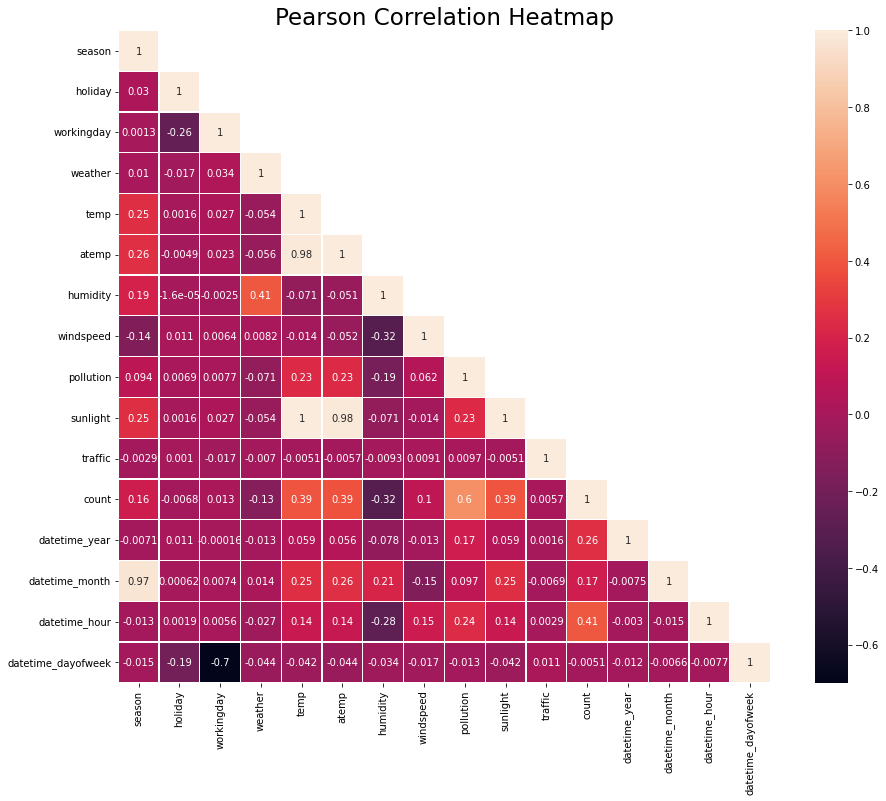

In [ ]:
corr_df = df_train.corr()
mask = np.zeros_like(corr_df, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

fig, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Heatmap', fontsize=23)

sns.heatmap(corr_df, linewidths=0.25, vmax=1.0, square=True ,
            linecolor='w', annot=True, mask=mask)

atemp feature is the average of temp feature, meaning it's a mathemathical manipulation of it, so we dropped temp.
In addition, seasons consist of months, so we decided to drop the season column.

In [ ]:
df_train.drop(['temp','season'],axis=1,inplace=True)
#for the result file
Features_dropped.append('temp')
Features_dropped.append('season')

let's see the distribution of every column

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c6c015c90>,
      dtype=object)

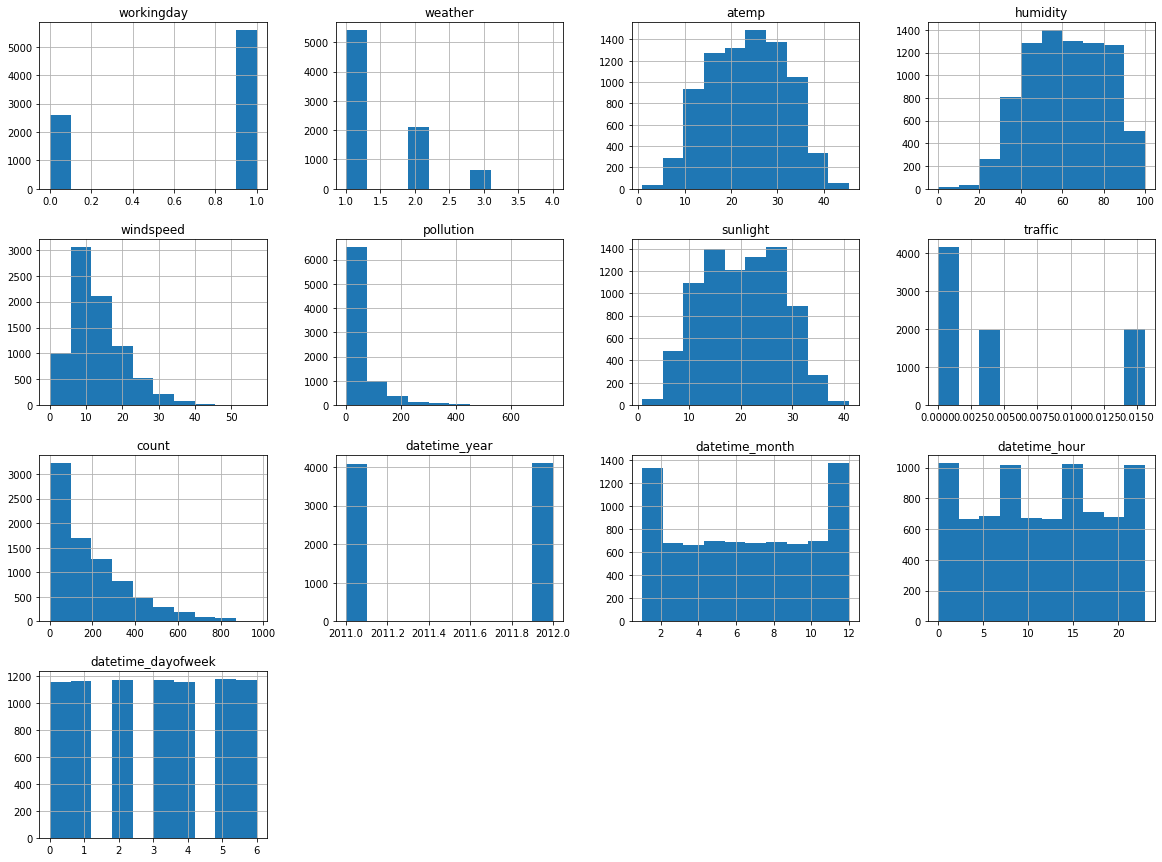

In [ ]:
df_train.iloc[:,1:].hist(figsize=(20,15))

We can see that "atemp", "humidity" and "sunlight" columns are near to Normally distributed.


Comparing the amount of bicycle rentals over the months and years

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across year'),
 None]

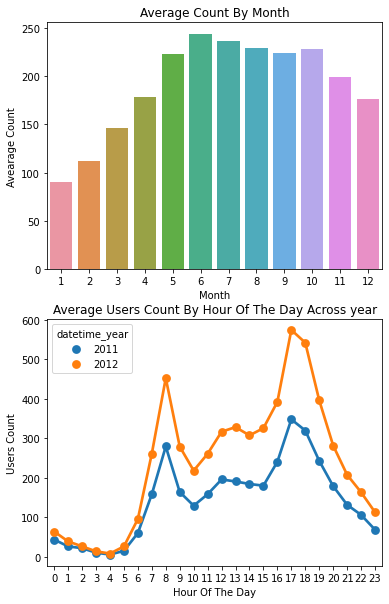

In [ ]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(6,10)
monthAggregated = pd.DataFrame(df_train.groupby("datetime_month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="datetime_month",y="count",ax=ax1)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(df_train.groupby(["datetime_hour","datetime_year"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["datetime_hour"], y=hourAggregated["count"],hue=hourAggregated["datetime_year"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across year",label='big')

We can see that the average bicycles rentals is higher in months 6-9.

In addition, it can be seen that in 2012 more bicycles were rented than in 2011. 

# Model selection

Since we replaced **datetime** column to numeric categorical columns: **'datetime_year', 'datetime_month', 'datetime_hour', 'datetime_dayofweek'**,
We chose our models mostly because their ability to natively handle numeric categorical variables. 

### Random Forest

In [ ]:
def run_random_forest(x_train, y_train):
  rf = RandomForestRegressor(n_estimators=500, random_state=42)
  tuned_rf = GridSearchCV(estimator=rf, 
                          param_grid={'max_features': ['auto', 'sqrt', 'log2', 1/3]},
                          scoring='neg_mean_squared_error',
                          cv=3, 
                          verbose=3,
                          refit=True)
  tuned_rf.fit(x_train, y_train)
  return tuned_rf

### XGB

In [ ]:
def run_XGB(x_train, y_train):
    xgb1 = XGBRegressor(n_estimators=500, random_state=42)
    parameters = {
                'learning_rate': [.03, 0.05, .07], #so called `eta` value
                'max_depth': [3,5,7]}

    xgb_grid = GridSearchCV(xgb1,
                            parameters,
                            cv = 3,
                            scoring='neg_mean_squared_error',
                            verbose=3)

    xgb_grid.fit(x_train,y_train)
    return xgb_grid

### Decision Tree

In [ ]:
def run_decision_tree(x_train, y_train):
  dt = DecisionTreeRegressor(random_state=42)
  tuned_dt = GridSearchCV(estimator=dt, 
                          param_grid={'max_features': ['auto', 'sqrt', 'log2', 1/3]},
                          scoring='neg_mean_squared_error',
                          cv=3, 
                          verbose=3)
  tuned_dt.fit(x_train, y_train)
  return tuned_dt

# Run all models


In [ ]:
X_train = df_train.drop(['count'], axis=1)
Y_train = df_train['count']

In [ ]:
def run_all_models(x, y):
  models_dict = {}

  start_Random_forest = time.time()
  models_dict['Random forest'] = run_random_forest(x, y)
  end_Random_forest = time.time()
  total_time_random_forest = end_Random_forest - start_Random_forest

  start_XGB = time.time()
  models_dict['XGB'] = run_XGB(x, y)
  end_XGB = time.time()
  total_time_XGB = end_XGB - start_XGB

  start_decision_tree = time.time()
  models_dict['decision tree'] = run_decision_tree(x, y)
  end_decision_tree = time.time()
  total_time_decision_tree = end_decision_tree - start_decision_tree

  return models_dict, total_time_random_forest, total_time_XGB, total_time_decision_tree

In [ ]:
models, total_time_random_forest, total_time_XGB, total_time_decision_tree = run_all_models(X_train, Y_train.values.ravel())
dict_time={}
dict_time['Random forest']=total_time_random_forest
dict_time['decision tree']=total_time_decision_tree
dict_time['XGB']=total_time_XGB

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END .............max_features=auto;, score=-2851.449 total time=  10.1s
[CV 2/3] END .............max_features=auto;, score=-3299.377 total time=  10.8s
[CV 3/3] END .............max_features=auto;, score=-3059.956 total time=  10.8s
[CV 1/3] END .............max_features=sqrt;, score=-5422.906 total time=   3.4s
[CV 2/3] END .............max_features=sqrt;, score=-5830.186 total time=   3.4s
[CV 3/3] END .............max_features=sqrt;, score=-5742.235 total time=   3.4s
[CV 1/3] END .............max_features=log2;, score=-5422.906 total time=   3.4s
[CV 2/3] END .............max_features=log2;, score=-5830.186 total time=   3.4s
[CV 3/3] END .............max_features=log2;, score=-5742.235 total time=   3.4s
[CV 1/3] END max_features=0.3333333333333333;, score=-4603.100 total time=   4.1s
[CV 2/3] END max_features=0.3333333333333333;, score=-4949.267 total time=   4.1s
[CV 3/3] END max_features=0.3333333333333333;, 

In [ ]:
cv_scores = {}
cv_scores['Random forest'] = np.sqrt(-models['Random forest'].best_score_)
cv_scores['XGB'] = np.sqrt(-models['XGB'].best_score_)
cv_scores['decision tree'] = np.sqrt(-models['decision tree'].best_score_)

cv_scores

{'Random forest': 55.409930221242625,
 'XGB': 43.915734780963,
 'decision tree': 78.75040309172334}

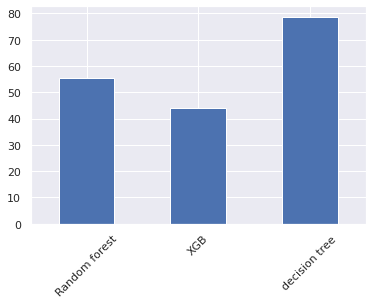

In [ ]:
sns.set()
cv_scores_df =pd.DataFrame.from_dict(cv_scores, orient='index')
cv_scores_df.plot.bar(rot=45, legend=False)

As we can see from the graph, XGB had the least RMSE error.

##Feature selection


To find features importance we  used sklearn's built-in methods:



In [ ]:
def find_feature_importance(model, columns):
  importance = model.feature_importances_
  importance *= 100 / np.max(importance)  # Normalize
  importance = pd.DataFrame(importance, index=columns, columns=["Importance"])
  importance = importance.sort_values(by=['Importance'], ascending=False)
  return importance

In [ ]:
feature_importance_dict = {}
feature_importance_dict['decision tree'] = find_feature_importance(models['decision tree'].best_estimator_, X_train.columns)
feature_importance_dict['Random forest'] = find_feature_importance(models['Random forest'].best_estimator_, X_train.columns)
feature_importance_dict['XGB'] = find_feature_importance(models['XGB'].best_estimator_, X_train.columns)

Let's visualize the different feature imprtance across the models:



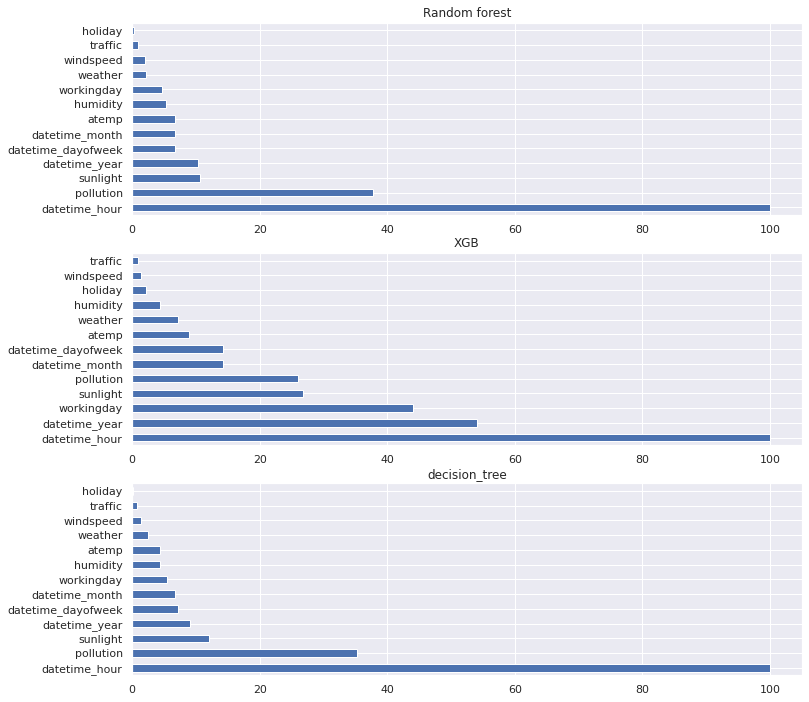

In [ ]:
sns.set()

fig, axes = plt.subplots(3, 1, figsize=(12, 12))
feature_importance_dict['Random forest'].plot(kind='barh', ax=axes[0], legend=False, title='Random forest')
feature_importance_dict['XGB'].plot(kind='barh', ax=axes[1], legend=False, title='XGB')
feature_importance_dict['decision tree'].plot(kind='barh', ax=axes[2], legend=False, title='decision_tree')

In [ ]:
strong_features_dict = {}
for k, v in feature_importance_dict.items():
  strong_features_dict[k] = list(v.index.values[:3])
strong_features_dict

{'decision tree': ['datetime_hour', 'pollution', 'sunlight'],
 'Random forest': ['datetime_hour', 'pollution', 'sunlight'],
 'XGB': ['datetime_hour', 'datetime_year', 'workingday']}

So in **decision tree**  and **random forest** the 3 most important features was: **'datetime_hour', 'pollution', 'sunlight'**

However **XGB** got two other most important features:
**'datetime_hour', 'datetime_year', 'workingday'**


Determine the final hyperparameters for the models according to their best estimate

In [ ]:
trained_models_dict = {}
trained_models_dict['Random forest'] = models['Random forest'].best_estimator_
trained_models_dict['decision tree'] = models['decision tree'].best_estimator_
trained_models_dict['XGB'] = models['XGB'].best_estimator_

trained_models_dict

{'Random forest': RandomForestRegressor(n_estimators=500, random_state=42),
 'decision tree': DecisionTreeRegressor(max_features='auto', random_state=42),
 'XGB': XGBRegressor(learning_rate=0.07, max_depth=7, n_estimators=500, random_state=42)}

##Prepare the test set for the same train's formt

take care the datetime column like the train set

In [ ]:
df_test=time_process(df_test)

check the test data has'nt null values like the train set

In [ ]:
df_test[df_test.isnull()].count()

season                0
holiday               0
workingday            0
weather               0
temp                  0
atemp                 0
humidity              0
windspeed             0
pollution             0
sunlight              0
traffic               0
count                 0
datetime_year         0
datetime_month        0
datetime_hour         0
datetime_dayofweek    0
dtype: int64

We drop the columns like we did on train set

In [ ]:
df_test.drop(['temp','season'],axis=1,inplace=True)

In [ ]:
X_test = df_test.drop(['count'], axis=1)
Y_test = df_test[['count']]

## Evaluating on test set

In [ ]:
def evaluate_single_model(x, y, model):
  y_pred = model.predict(x)
  return np.sqrt( mean_squared_error(y, y_pred))

In [ ]:
def evaluate_all_models(x, y, models_dict,dict_time):
  test_set_scores = {}
  for k, v in models_dict.items():
    strat=time.time()
    test_set_scores[k] = evaluate_single_model(x, y, v)
    end=time.time()
    dict_time[k]+=(end-strat)
  return test_set_scores,dict_time

In [ ]:
test_set_scores,dict_time = evaluate_all_models(X_test, Y_test, trained_models_dict,dict_time)
test_set_scores

{'Random forest': 46.36715245762517,
 'decision tree': 66.22250583605596,
 'XGB': 39.62176105617667}

In [ ]:
results = {'model': test_set_scores.keys(),
           'Score (RMSE)': test_set_scores.values(),
           'Hyperparams used': trained_models_dict.values(),
           'Features dropped': [Features_dropped, Features_dropped, Features_dropped],
           'New features created': [New_features_created, New_features_created, New_features_created],
           'Runtime trainining + inference (seconds)':dict_time.values(),
           'Hardware used (GPU/CPU/TPU)': ['CPU', 'CPU', 'CPU'],
           'Explainability (top 3 features)': [strong_features_dict['Random forest'], strong_features_dict['decision tree'], strong_features_dict['XGB']]
           }

df = pd.DataFrame(results)
df

,model,Score (RMSE),Hyperparams used,Features dropped,New features created,Runtime trainining + inference (seconds),Hardware used (GPU/CPU/TPU),Explainability (top 3 features)
0,Random forest,46.367152,"(DecisionTreeRegressor(max_features='auto', ra...","[datetime, temp, season]","[datetime_year, datetime_month, datetime_hour,...",84.532425,CPU,"[datetime_hour, pollution, sunlight]"
1,decision tree,66.222506,"DecisionTreeRegressor(max_features='auto', ran...","[datetime, temp, season]","[datetime_year, datetime_month, datetime_hour,...",0.301704,CPU,"[datetime_hour, pollution, sunlight]"
2,XGB,39.621761,"XGBRegressor(learning_rate=0.07, max_depth=7, ...","[datetime, temp, season]","[datetime_year, datetime_month, datetime_hour,...",62.419672,CPU,"[datetime_hour, datetime_year, workingday]"


We can see that XGB has the best score (because we want the lower RMSE). In addition his total runtime (train and evaluate) is smaller than Random forest. We chose to use GridSearchCV method for choosing the hyperparams of each model. We chose CPU hardware, because we didn't use NN model which requires GPU and it has higher price.

In [ ]:
df.to_csv(os.path.join(os.getcwd(), 'exercise1.csv'))